# State Construction Task

In [12]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt

generates equidistributed points on unit nd-sphere (see [here](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf))

In [1]:
def equidistributed_points(dim, approx_N):
    a = 4*np.pi / approx_N
    d = np.sqrt(a)
    m_theta = np.round(np.pi / d)
    d_theta = np.pi / m_theta
    d_phi = a / d_theta
    for t in range(m_theta):
        theta = (t + 0.5) * d_theta
        m_phi = round(2 * np.pi * sin(theta) / d_phi)
        for p in range(m_phi):
            phi = 2 * np.pi * p / m_phi
            yield (theta, phi)

In [ ]:
equi

generate a parametric hamiltonian with `tf.Variable`

In [3]:
def generate_hamiltonain(dim):
    def generate_parametric(n, dv_lambda):
        params = tf.cast(tf.Variable(tf.random_normal((n, ))), 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(places, params, axes=[0, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag) + generate_parametric(dim, diag)
    
    return h

implement the optimization problem as a computation graph

In [4]:
def generate_graph(dim):
    source = tf.constant(np.array([1] + [0] * (dim - 1)), dtype='complex128')
    target_vec = np.random.normal(size=(dim,)) + 1j * np.random.normal(size=(dim,)) 
    target_vec /= np.linalg.norm(target_vec)
    target= tf.constant(target_vec, dtype='complex128')

    h = generate_hamiltonain(dim)
    gate = tf.linalg.expm(1j * h)
    estimated_target = tf.matmul(gate, tf.expand_dims(source, 1))

    target_dot = tf.matmul(tf.expand_dims(target, 1), estimated_target, adjoint_a=True)
    fidelity = tf.abs(target_dot)
    loss = 1 - fidelity

    summary_op = tf.summary.scalar('fidelity', fidelity)
    optimize_op = tf.train.MomentumOptimizer(momentum=0.8,learning_rate=0.5).minimize(loss)
    return optimize_op, fidelity

storing metrics (using tensorboard)

In [5]:
def plot_matrix(h):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(h, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Matrix")
    plt.colorbar()

    threshold = h.max() / 2.
    for i, j in itertools.product(range(h.shape[0]), range(h.shape[1])):
        color = "white" if h[i, j] > threshold else "black"
        plt.text(j, i, h[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    return figure

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

run the whole

In [6]:
folder = './tensorboard_logs/%s' % datetime.now().isoformat()
dim = 8
fs = []
tf.reset_default_graph()
with tf.Session() as session:
    for _ in tqdm(range(100)):
        optimize_op, fidelity_op = generate_graph(dim)
        init_op = tf.global_variables_initializer()
        session.run(init_op)2
        for i in range(5000):
            _, f = session.run([optimize_op, fidelity_op])
        fs.append(f)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0814 16:14:52.734215 140268744074880 deprecation.py:323] From /home/sajad/Works/Quantum/quantum-state-construction/venv/lib/python3.7/site-packages/tensorflow/python/ops/linalg/linalg_impl.py:280: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 100/100 [08:34<00:00,  6.96s/it]


(array([ 2.,  0.,  1.,  0.,  3.,  7.,  3.,  8., 20., 56.]),
 array([0.93851374, 0.94466237, 0.95081099, 0.95695962, 0.96310825,
        0.96925687, 0.9754055 , 0.98155412, 0.98770275, 0.99385137,
        1.        ]),
 <a list of 10 Patch objects>)

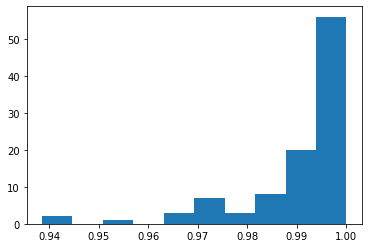

In [11]:
plt.hist([float(f) for f in fs])